In [1]:
from math import cos,sin,sqrt,pi
import opensees
import opensees.tcl
from opensees.units.english import *
from opensees import section, layer, patch, element, uniaxial
from opensees.render import mpl as render

### Concrete

In [2]:
# MATERIAL parameters -------------------------------------------------------------------
IDconcU = 1                # material ID tag -- unconfined cover concrete

# nominal concrete compressive strength
fc = -4.0*ksi              # Concrete Compressive Strength ksi
Ec = 57*ksi*sqrt(-fc/psi)  # Concrete Elastic Modulus

# unconfined concrete
fc1U    =  fc              # UNCONFINED concrete (todeschini parabolic model) maximum stress
eps1U   = -0.003           # strain at maximum strength of unconfined concrete
fc2U    =  0.2*fc1U        # ultimate stress
eps2U   = -0.01            # strain at ultimate stress
_lambda =  0.1             # ratio between unloading slope at eps2 and initial slope Ec

# tensile-strength properties
ftU = -0.14*fc1U           # tensile strength +tension
Ets =  ftU/0.002           # tension softening stiffness

In [3]:
concU = uniaxial.Concrete02(IDconcU, fc1U, eps1U, fc2U, eps2U, _lambda, ftU, Ets)      # build 'cover, concrete (unconfined)

### Steel

In [4]:
IDreinf = 2        # material ID tag -- reinforcement
Fy = 66.8*ksi      # yield stress
Es = 29000.*ksi    # modulus of steel
Bs = 0.005         # strain-hardening ratio 
R0 = 18            # control transition from elastic to plastic branches
cR1 = 0.925        # control transition from elastic to plastic branches
cR2 = 0.15         # control transition from elastic to plastic branches
reinf = uniaxial.Steel02(IDreinf, Fy, Es, Bs, R0, cR1, cR2)  

## Section Geometry

<!--
```
                      y
                      ^
                      |     
           ---------------------     --   --
           |   o     o     o   |     |    -- cover
           |                   |     |
           |                   |     |
    z <--- |         +         |     H
           |                   |     |
           |                   |     |
           |   o     o     o   |     |    -- cover
           ---------------------     --   --
           |-------- B ---------|
```
-->

In [5]:
HSec = 5.*ft            # Column Depth
BSec = 3.*ft            # Column Width
coverSec = 5.*inch      # Column cover to reinforcing steel NA.
numBarsSec = 4          # number of longitudinal-reinforcement bars in steel layer. (symmetric top & bot)
barAreaSec = 1*in2      # area of longitudinal-reinforcement bars
SecTag = 1              # tag = for symmetric section

# FIBER SECTION properties -------------------------------------------------------------
# RC section: 
coverY = HSec/2.0        # Distance from section z-axis to edge of cover concrete -- outer edge of cover concrete
coverZ = BSec/2.0        # Distance from section y-axis to edge of cover concrete -- outer edge of cover concrete
coreY = coverY-coverSec  # Distance from section z-axis to edge of core concrete --  edge of the core concrete/inner edge of cover concrete
coreZ = coverZ-coverSec  # Distance from section y-axis to edge of core concrete --  edge of the core concrete/inner edge of cover concrete
nfY = 16                 # number of fibers for concrete in y-direction
nfZ = 8                  # number of fibers for concrete in z-direction

In [6]:
# Define the fiber section
geom =  [
    # patch.quad(concU, [nfZ, nfY], [[-coverZ, coverY],[-coverZ, -coverY],[coverZ, -coverY],[coverZ, coverY]]),
    patch.rect(concU, [nfZ, nfY], [[-coverZ, -coverY], [coverZ, coverY]]),
    layer.line(reinf, numBarsSec, barAreaSec, [[-coreZ, coreY],[ coreZ,  coreY]]),  # top layer reinforcement
    layer.line(reinf, numBarsSec, barAreaSec, [[-coreZ,-coreY],[ coreZ, -coreY]]),  # bottom layer reinfocement
]
sect = section.FiberSection(SecTag,  1e6, geom)

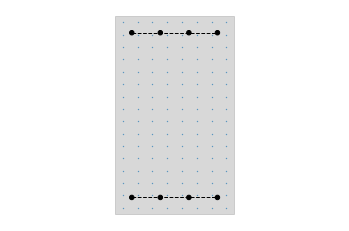

In [7]:
render.section(sect);

## Analysis

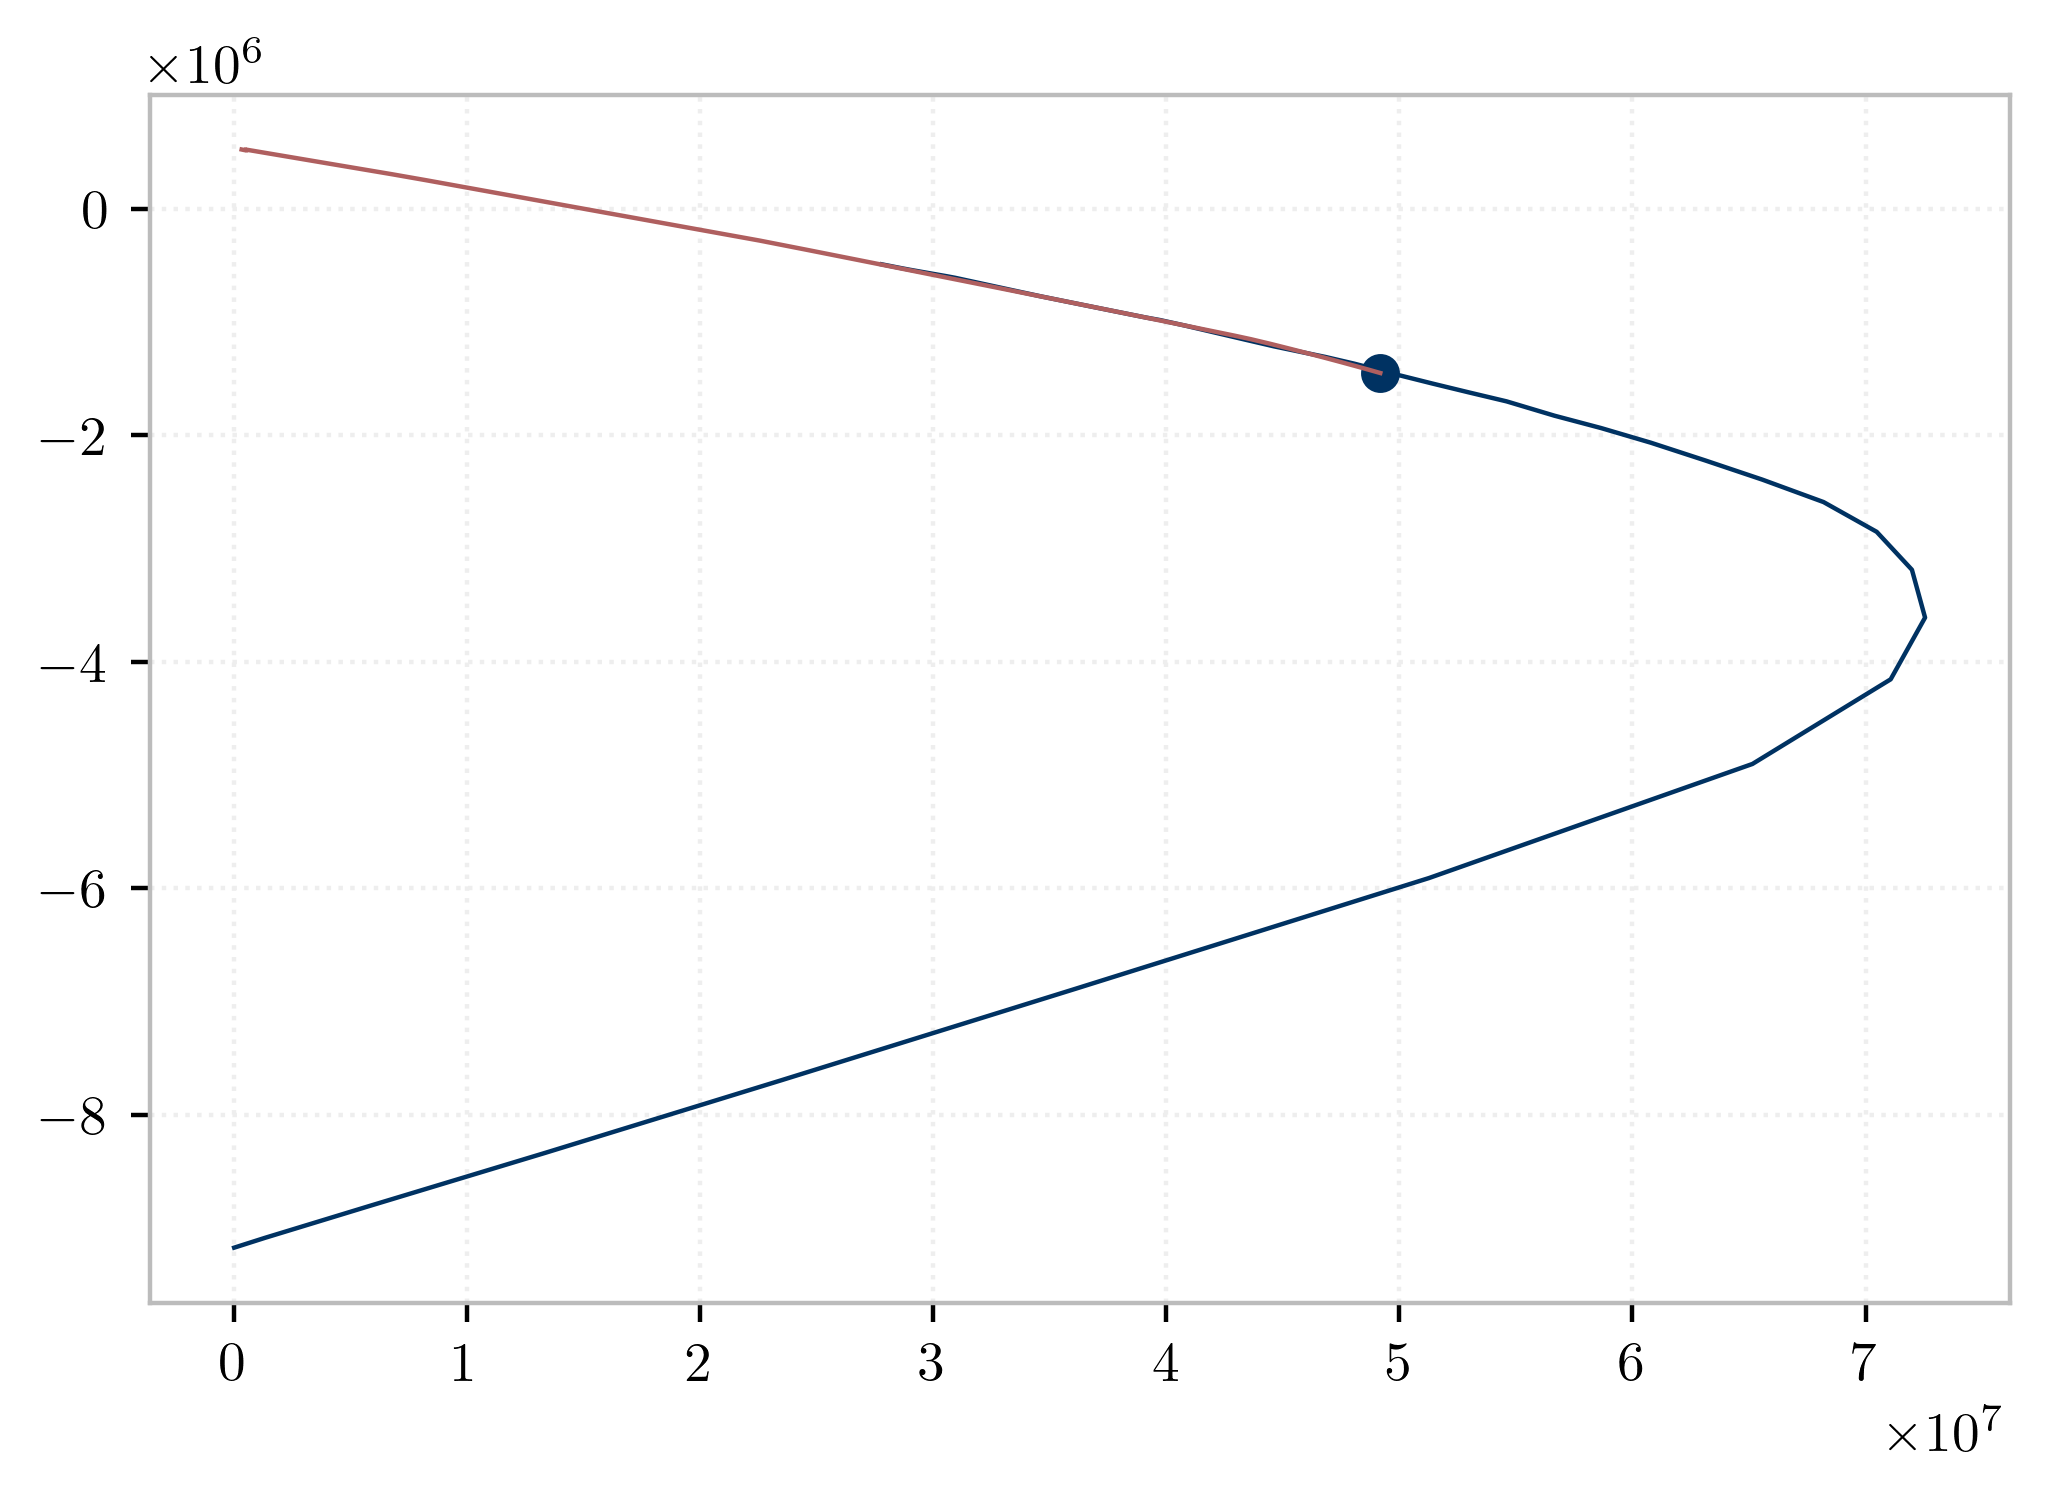

In [12]:
import numpy as np

n = 50
crush_strain = -0.003
yield_strain =  0.002

steel_strain = np.linspace( crush_strain, 10.0*yield_strain, n)
curvature_A = (steel_strain - crush_strain)/(HSec - coverSec)
axial_strain_A = crush_strain + HSec/2*curvature_A


d = (HSec - 2*coverSec)
tens, comp = np.linspace([crush_strain, 10.0*yield_strain],
                         [yield_strain,      yield_strain], n).T

curvature_B = (tens + comp)/d
axial_strain_B = tens + d/2*curvature_B


axial_strain = np.array([
    *axial_strain_A, 
    *axial_strain_B
])
curvature = np.array([
    *curvature_A, 
    *curvature_B
])


with sect as S:
    P, M = zip(*[
        S.getStressResultant([e,k], False)
                 for e,k in zip(axial_strain, curvature)
    ])



import matplotlib.pyplot as plt
plt.style.use("typewriter")
# plt.plot(*zip(*s));
plt.plot(M[:n], P[:n])
plt.plot(M[n:], P[n:])
plt.scatter(M[n],P[n]);